In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf # 런타임 재시작 필요

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import torch
import os

SEED = 42

DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/대구 교통사고 피해 예측/data/'

In [4]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False


seed_everything(SEED)

In [5]:
# 전국 데이터로 돌려보기

# country_acc = pd.read_csv(f'{DATA_PATH}countrywide_accident.csv') #

# KR_cctv = pd.read_csv(f'{DATA_PATH}전국무인교통단속카메라표준데이터.csv', encoding='cp949')
DG_cctv = pd.read_csv(f'{DATA_PATH}대구 CCTV 정보.csv', encoding='cp949')

# KR_seculight =pd.read_csv(f'{DATA_PATH}전국보안등정보표준데이터.csv', encoding='cp949')
DG_seculight = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')

# KR_children_area = pd.read_csv(f'{DATA_PATH}전국어린이보호구역표준데이터.csv', encoding='cp949')
DG_children_area = pd.read_csv(f'{DATA_PATH}대구 어린이 보호 구역 정보.csv', encoding='cp949')

# KR_parking = pd.read_csv(f'{DATA_PATH}전국주차장정보표준데이터.csv', encoding='cp949')
DG_parking = pd.read_csv(f'{DATA_PATH}대구 주차장 정보.csv', encoding='cp949')

train = pd.read_csv(f'{DATA_PATH}train.csv')
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

<ipython-input-5-4b58cf1a2cac>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DG_seculight = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')


In [6]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [7]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

# test 데이터 반영
test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [8]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

# test 데이터 반영
test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

# EDA

In [9]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

In [10]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2'],
      dtype='object')

In [11]:
train_df['구'].value_counts() # 총 8개의 구

달서구    9891
수성구    6707
북구     6650
동구     5341
서구     3495
달성군    2767
남구     2559
중구     2199
Name: 구, dtype: int64

In [12]:
train_df['동'].value_counts() # 총 196개의 동

대명동      1749
범어동      1173
상인동      1143
비산동       968
내당동       938
         ... 
완전동         2
신용동         2
동성로1가       2
도남동         2
평광동         1
Name: 동, Length: 196, dtype: int64

In [13]:
train_eda = train_df.copy()
test_eda = test_df.copy()

In [14]:
from sklearn.preprocessing import LabelEncoder

categorical_features = list(train_eda.dtypes[train_df.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

['ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 연령',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 연령',
 '피해운전자 상해정도',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2']

In [15]:
for i in categorical_features:
    le = LabelEncoder()
    train_eda[i] = le.fit_transform(train_eda[i])
    # test_eda[i] = le.transform(test_eda[i])
display(train_eda.head())
display(train_eda.corr()['ECLO'].sort_values(ascending=False))

#사고유형이 가장 중요함

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,0,6,2,0,0,2,7,5,2,42,...,5,2019,1,1,0,0,7,40,2,5
1,1,6,5,0,0,5,2,5,1,29,...,3,2019,1,1,0,0,1,4,2,5
2,2,6,2,0,0,9,7,5,1,62,...,3,2019,1,1,1,0,6,66,2,5
3,3,6,2,0,1,10,7,5,1,39,...,5,2019,1,1,2,0,4,79,2,5
4,4,6,2,0,1,10,7,5,1,20,...,3,2019,1,1,4,0,3,129,2,5


ECLO           1.000000
경상자수           0.636370
중상자수           0.464520
사망자수           0.218507
사고유형           0.103219
사고유형 - 세부분류    0.097998
피해운전자 상해정도     0.076734
가해운전자 성별       0.043198
요일             0.027895
노면상태           0.015810
기상상태           0.009092
구              0.001646
가해운전자 차종      -0.006869
월             -0.006871
피해운전자 연령      -0.007016
동             -0.007475
일             -0.012303
피해운전자 차종      -0.016851
시간            -0.017355
법규위반          -0.021637
연             -0.031281
ID            -0.032306
도로형태1         -0.035695
피해운전자 성별      -0.037084
도로형태2         -0.049645
가해운전자 연령      -0.051708
가해운전자 상해정도    -0.081077
부상자수          -0.118713
도시                  NaN
Name: ECLO, dtype: float64

In [16]:
display(train_eda.corr()['사고유형 - 세부분류'].sort_values(ascending=False))


사고유형 - 세부분류    1.000000
경상자수           0.113625
ECLO           0.097998
사고유형           0.083999
가해운전자 성별       0.056608
구              0.038317
가해운전자 상해정도     0.022730
연              0.008784
ID             0.006364
기상상태           0.006221
가해운전자 차종       0.005423
시간             0.004155
동              0.003485
일              0.003300
중상자수           0.001383
요일            -0.001501
월             -0.001997
노면상태          -0.010013
사망자수          -0.015917
법규위반          -0.023955
가해운전자 연령      -0.026345
피해운전자 차종      -0.028678
부상자수          -0.032889
도로형태2         -0.088460
도로형태1         -0.090454
피해운전자 연령      -0.118267
피해운전자 상해정도    -0.121256
피해운전자 성별      -0.126248
도시                  NaN
Name: 사고유형 - 세부분류, dtype: float64

In [17]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

In [18]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [19]:
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

Text(0.5, 1.0, '동별 ECLO')

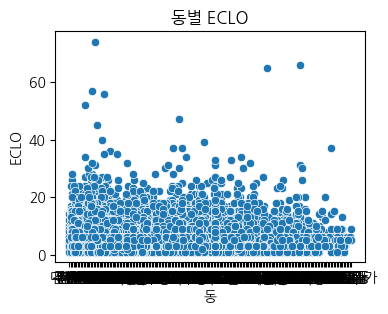

In [20]:
plt.figure(figsize= (4,3))
sns.scatterplot(x=train_df['동'], y=train_df.ECLO)
plt.title(f'동별 ECLO')

In [21]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

  0%|          | 0/28 [00:00<?, ?it/s]

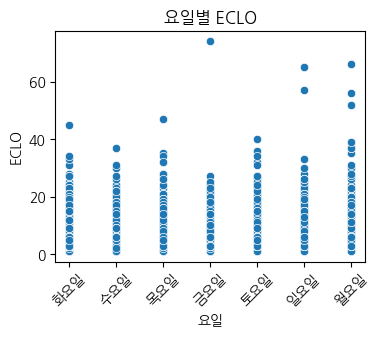

  4%|▎         | 1/28 [00:01<00:27,  1.01s/it]

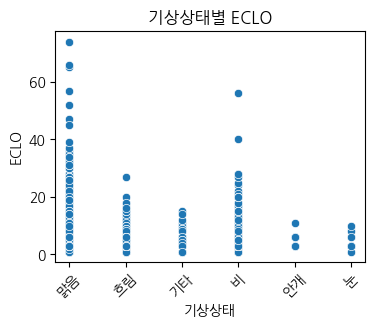

  7%|▋         | 2/28 [00:02<00:26,  1.00s/it]

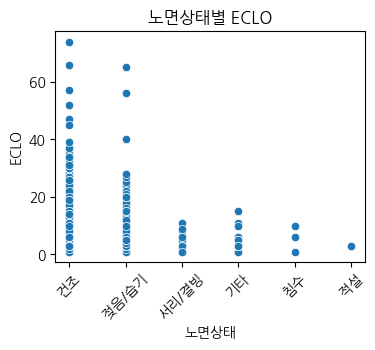

 11%|█         | 3/28 [00:02<00:19,  1.29it/s]

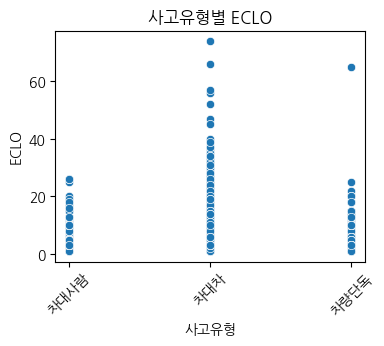

 14%|█▍        | 4/28 [00:03<00:15,  1.51it/s]

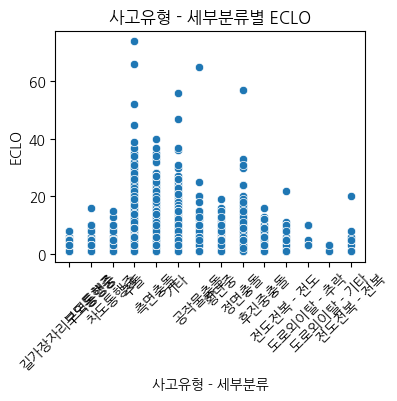

 18%|█▊        | 5/28 [00:03<00:14,  1.55it/s]

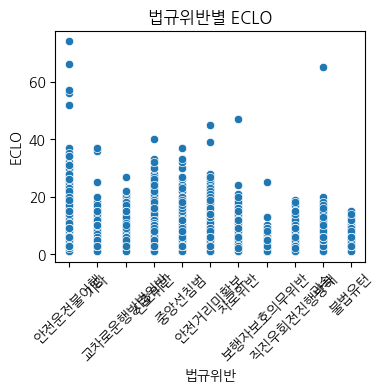

 21%|██▏       | 6/28 [00:04<00:13,  1.62it/s]

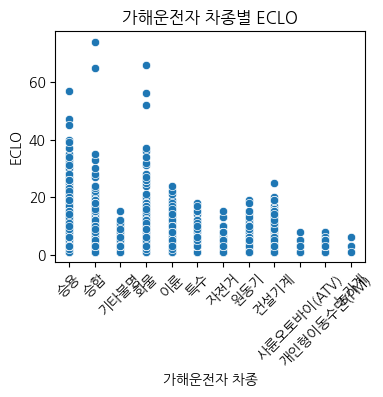

 25%|██▌       | 7/28 [00:04<00:12,  1.73it/s]

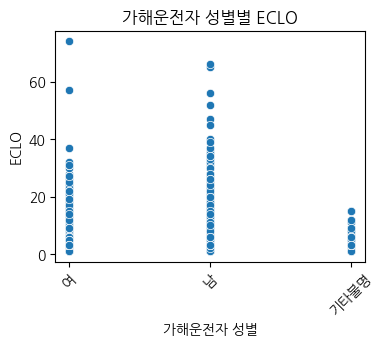

 29%|██▊       | 8/28 [00:05<00:11,  1.78it/s]

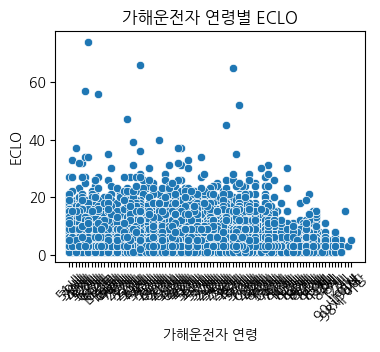

 32%|███▏      | 9/28 [00:06<00:13,  1.36it/s]

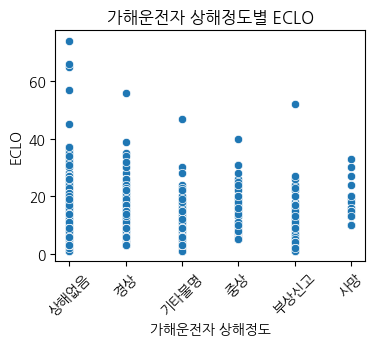

 36%|███▌      | 10/28 [00:06<00:12,  1.47it/s]

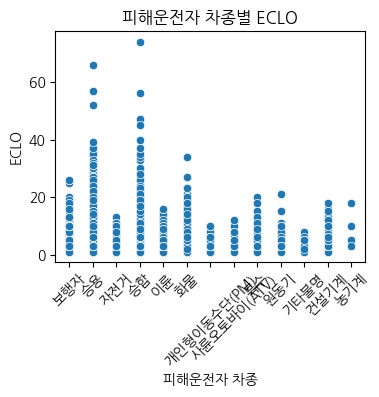

 39%|███▉      | 11/28 [00:07<00:11,  1.53it/s]

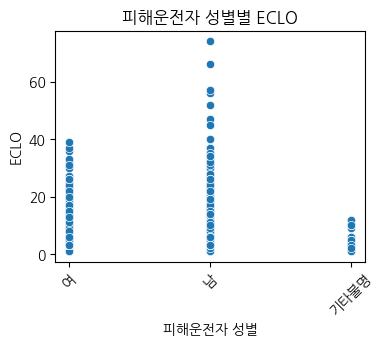

 43%|████▎     | 12/28 [00:07<00:09,  1.63it/s]

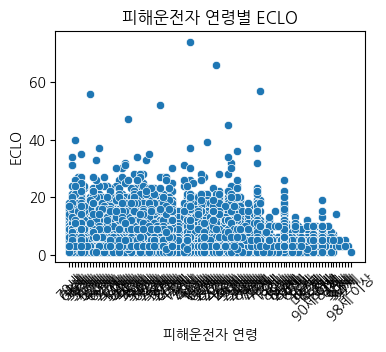

 46%|████▋     | 13/28 [00:09<00:12,  1.23it/s]

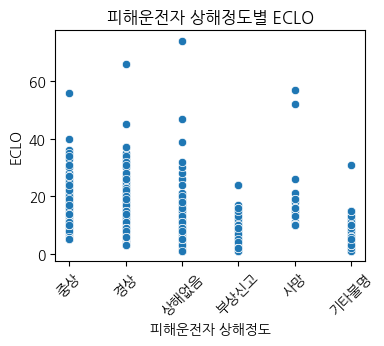

 50%|█████     | 14/28 [00:09<00:09,  1.48it/s]

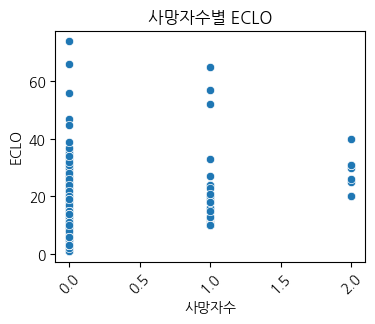

 54%|█████▎    | 15/28 [00:09<00:07,  1.75it/s]

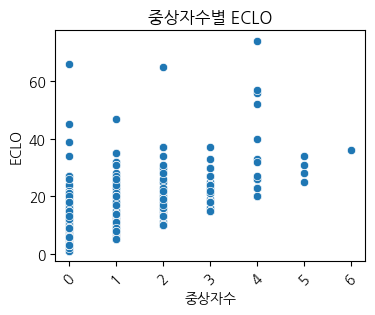

 57%|█████▋    | 16/28 [00:10<00:06,  1.97it/s]

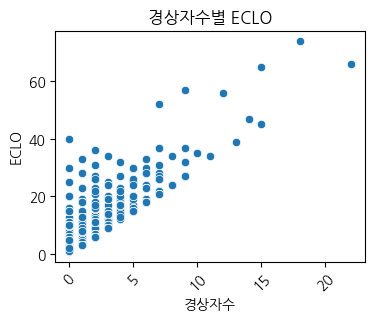

 61%|██████    | 17/28 [00:10<00:04,  2.21it/s]

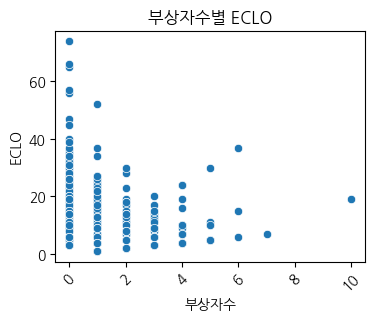

 64%|██████▍   | 18/28 [00:10<00:04,  2.42it/s]

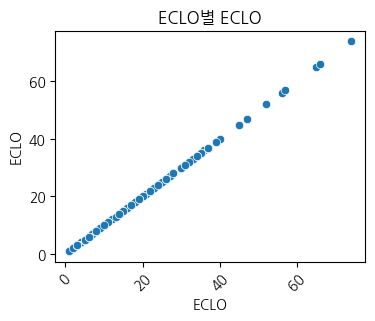

 68%|██████▊   | 19/28 [00:11<00:03,  2.58it/s]

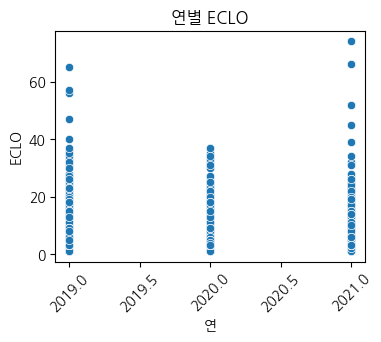

 71%|███████▏  | 20/28 [00:11<00:02,  2.72it/s]

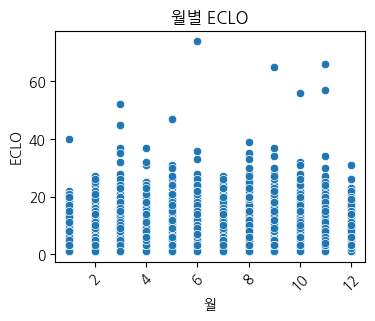

 75%|███████▌  | 21/28 [00:11<00:02,  2.83it/s]

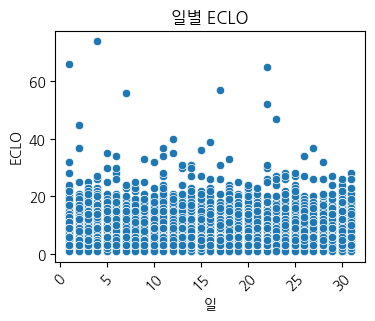

 79%|███████▊  | 22/28 [00:12<00:02,  2.43it/s]

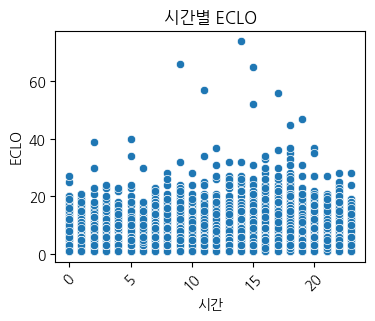

 82%|████████▏ | 23/28 [00:12<00:01,  2.63it/s]

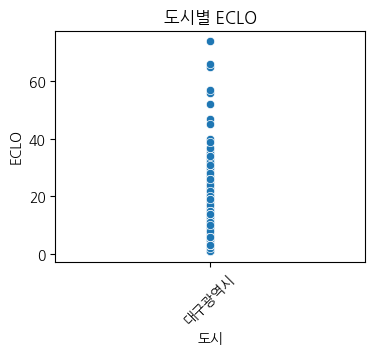

 86%|████████▌ | 24/28 [00:13<00:01,  2.79it/s]

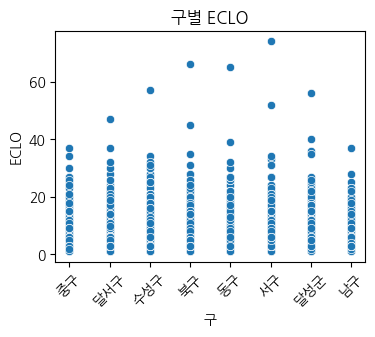

 89%|████████▉ | 25/28 [00:13<00:01,  2.70it/s]

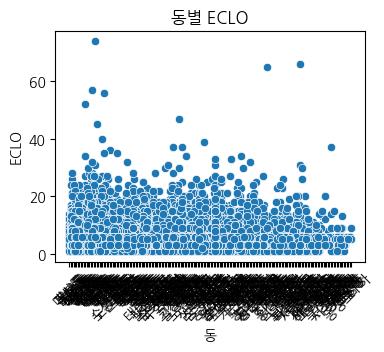

 93%|█████████▎| 26/28 [00:14<00:01,  1.52it/s]

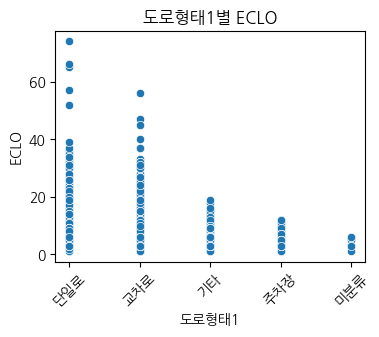

 96%|█████████▋| 27/28 [00:15<00:00,  1.77it/s]

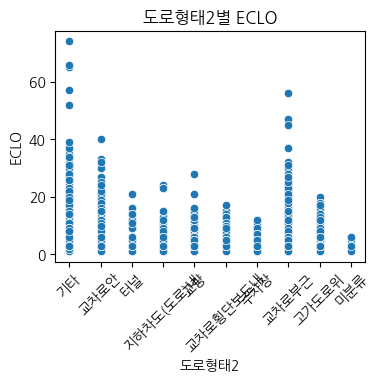

100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


In [22]:
from tqdm import tqdm

for col in tqdm(train_df.iloc[:,1:].columns) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

In [23]:
train_df.groupby(['도시','구','동'])[['ECLO']].std().reset_index()

,도시,구,동,ECLO
0,대구광역시,남구,대명동,2.888582
1,대구광역시,남구,봉덕동,3.473655
2,대구광역시,남구,이천동,2.798144
3,대구광역시,달서구,갈산동,2.966311
4,대구광역시,달서구,감삼동,2.843737
...,...,...,...,...
194,대구광역시,중구,태평로3가,3.701611
195,대구광역시,중구,포정동,3.292182
196,대구광역시,중구,하서동,10.964589
197,대구광역시,중구,향촌동,0.894427


## 보안등

In [24]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_seculight[['도시', '구', '동','번지']] = DG_seculight['소재지지번주소'].str.extract(location_pattern)
DG_seculight = DG_seculight.drop(columns=['소재지지번주소'])

DG_seculight

,보안등위치명,설치개수,소재지도로명주소,위도,경도,설치연도,설치형태,도시,구,동,번지
0,대명1동1,1,대구광역시 남구 현충로 155,35.846703,128.579803,2016.0,한전주,대구광역시,남구,대명동,1722-4
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,35.846863,128.579406,2016.0,한전주,대구광역시,남구,대명동,1723-11
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,35.846341,128.579342,2017.0,건축물,대구광역시,남구,대명동,1722-56
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,35.846368,128.578922,2016.0,한전주,대구광역시,남구,대명동,1722-41
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,35.845995,128.578858,2016.0,한전주,대구광역시,남구,대명동,1721-22
...,...,...,...,...,...,...,...,...,...,...,...
71908,대봉2동 165-9,1,NaN,35.857556,128.600023,NaN,한전주,대구광역시,중구,대봉동,165-9
71909,대봉2동 88-85,1,NaN,35.859205,128.600046,NaN,한전주,대구광역시,중구,대봉동,88-85
71910,대봉2동 719-20,1,NaN,35.859442,128.599627,NaN,한전주,대구광역시,중구,대봉동,719-20
71911,대봉2동 738-13,1,NaN,35.858244,128.597614,2010.0,건축물,대구광역시,중구,대봉동,738-13


In [25]:
df1 = DG_seculight.groupby(['도시','구','동'])[['설치개수']].sum().reset_index()
df1.columns = ['도시','구','동','보안등_설치개수']

In [26]:
DG_seculight['설치형태'].value_counts()

한전주    26466
건축물     7316
전용주     1591
Name: 설치형태, dtype: int64

In [27]:
df2 = pd.get_dummies(DG_seculight['설치형태'], prefix='보안등')
df2 = pd.concat([DG_seculight[['도시','구','동']], df2], axis=1)
df2 = df2.groupby(['도시','구','동']).sum().reset_index().drop(columns =['도시','구','동'])

seculight_merge = pd.concat([df1, df2], axis=1)

train_df = pd.merge(train_df,seculight_merge, on = ['도시','구','동'], how='left')
test_df = pd.merge(test_df,seculight_merge, on = ['도시','구','동'], how='left')

display(seculight_merge.head(3))
display(train_df.head(3))
display(test_df.head(3))

,도시,구,동,보안등_설치개수,보안등_건축물,보안등_전용주,보안등_한전주
0,대구광역시,남구,대명동,5377,1647,20,3583
1,대구광역시,남구,봉덕동,1424,394,22,974
2,대구광역시,남구,이천동,556,192,13,346


,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,시간,도시,구,동,도로형태1,도로형태2,보안등_설치개수,보안등_건축물,보안등_전용주,보안등_한전주
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,0,대구광역시,중구,대신동,단일로,기타,391.0,177.0,30.0,135.0
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,0,대구광역시,달서구,감삼동,단일로,기타,932.0,0.0,0.0,0.0
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,1,대구광역시,수성구,두산동,단일로,기타,473.0,14.0,31.0,425.0


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,보안등_설치개수,보안등_건축물,보안등_전용주,보안등_한전주
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,700.0,104.0,16.0,579.0
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,NaN,NaN,NaN,NaN
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,NaN,NaN,NaN


In [28]:
train_df.shape, test_df.shape

((39609, 33), (10963, 18))

In [29]:
train_df.columns[-4:]

Index(['보안등_설치개수', '보안등_건축물', '보안등_전용주', '보안등_한전주'], dtype='object')

  0%|          | 0/4 [00:00<?, ?it/s]

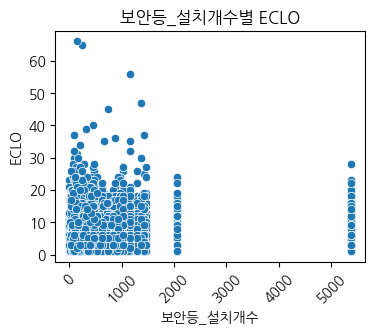

 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

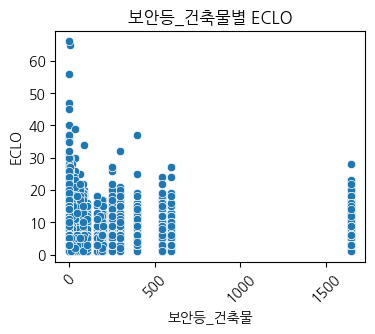

 50%|█████     | 2/4 [00:00<00:00,  3.15it/s]

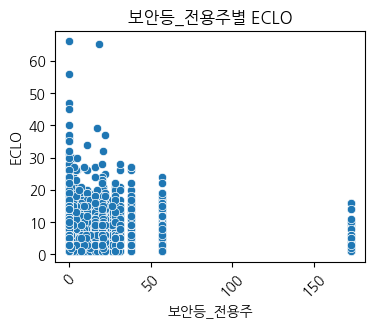

 75%|███████▌  | 3/4 [00:00<00:00,  3.08it/s]

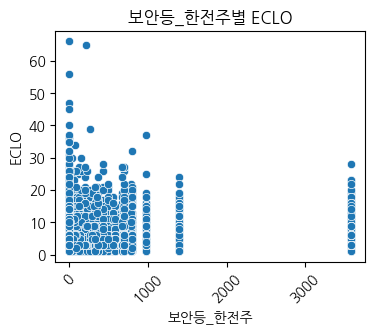

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


In [30]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-4:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

## cctv

In [31]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_cctv[['도시', '구', '동','번지']] = DG_cctv['소재지지번주소'].str.extract(location_pattern)
DG_cctv = DG_cctv.drop(columns=['소재지지번주소'])

DG_cctv

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [32]:
train_df['동'].value_counts() # 사고 횟수

대명동      1749
범어동      1173
상인동      1143
비산동       968
내당동       938
         ... 
완전동         2
신용동         2
동성로1가       2
도남동         2
평광동         1
Name: 동, Length: 196, dtype: int64

In [33]:
# 동별 최빈값으로 cctv 처리  -> one hot이 효과더 좋음

# df = DG_cctv[['도시','구','동']]
# df1 = DG_cctv.groupby(['도시', '구', '동'])[['보호구역구분']].apply(lambda x: x.mode()).reset_index()[['보호구역구분']]
# df2 = DG_cctv.groupby(['도시', '구', '동'])[['단속구분']].apply(lambda x: x.mode()).reset_index()[['단속구분']]
# df3 = DG_cctv.groupby(['도시', '구', '동'])[['도로종류']].apply(lambda x: x.mode()).reset_index()[['도로종류']]
# df4 = DG_cctv.groupby(['도시', '구', '동'])[['제한속도']].apply(lambda x: x.mode()).reset_index()[['제한속도']]

# cctv_merge= pd.concat([df, df1, df2, df3, df4], axis=1)
# cctv_merge #23개 열

# train_df = train_df.merge(cctv_merge, on = ['도시','구','동'], how='left')
# test_df = test_df.merge(cctv_merge, on = ['도시','구','동'], how='left')

In [34]:
# 수치형 - 동별 sum

In [35]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_cctv[['도시','구','동']]

df1 = pd.get_dummies(DG_cctv['보호구역구분'], prefix = '보호구역구분')
df2 = pd.get_dummies(DG_cctv['단속구분'], prefix = '단속구분')
df3 = pd.get_dummies(DG_cctv['도로종류'], prefix = '도로종류')
df4 = pd.get_dummies(DG_cctv['제한속도'], prefix = '제한속도')

cctv_merge= pd.concat([df, df1, df2, df3, df4], axis=1)
cctv_merge #23개 열

train_df = train_df.merge(cctv_merge, on = ['도시','구','동'], how='left')
test_df = test_df.merge(cctv_merge, on = ['도시','구','동'], how='left')

In [36]:
train_df.columns[-23:]

Index(['보호구역구분_1.0', '보호구역구분_2.0', '보호구역구분_99.0', '단속구분_1', '단속구분_2', '단속구분_4',
       '단속구분_99', '도로종류_고속국도', '도로종류_구도', '도로종류_군도', '도로종류_시도', '도로종류_일반국도',
       '도로종류_지방도', '도로종류_특별시도', '제한속도_0', '제한속도_30', '제한속도_40', '제한속도_50',
       '제한속도_60', '제한속도_70', '제한속도_80', '제한속도_100', '제한속도_110'],
      dtype='object')

  0%|          | 0/23 [00:00<?, ?it/s]

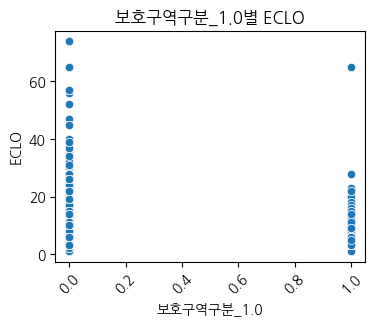

  4%|▍         | 1/23 [00:01<00:35,  1.60s/it]

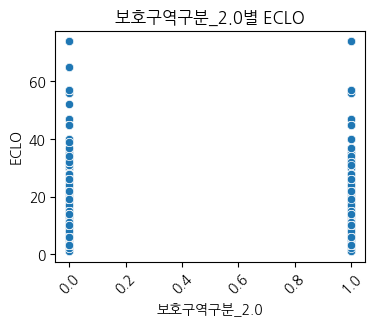

  9%|▊         | 2/23 [00:03<00:37,  1.80s/it]

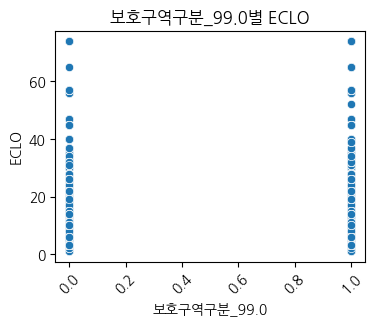

 13%|█▎        | 3/23 [00:05<00:36,  1.83s/it]

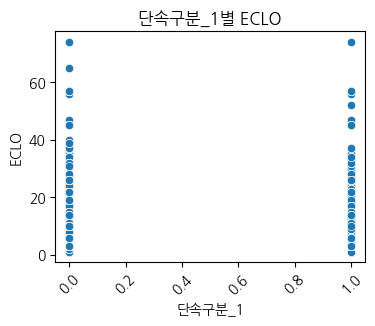

 17%|█▋        | 4/23 [00:07<00:35,  1.88s/it]

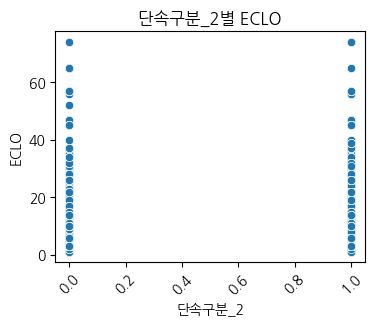

 22%|██▏       | 5/23 [00:09<00:32,  1.82s/it]

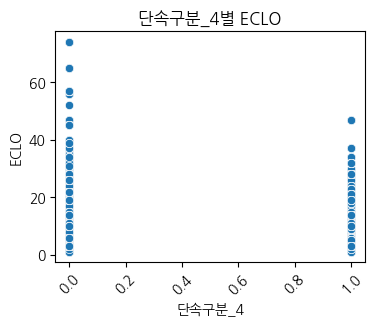

 26%|██▌       | 6/23 [00:10<00:28,  1.66s/it]

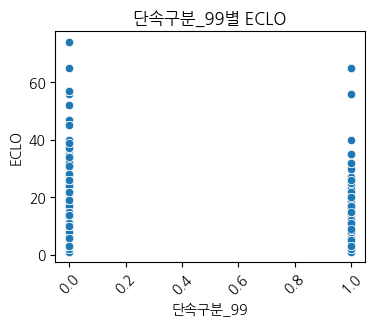

 30%|███       | 7/23 [00:11<00:24,  1.56s/it]

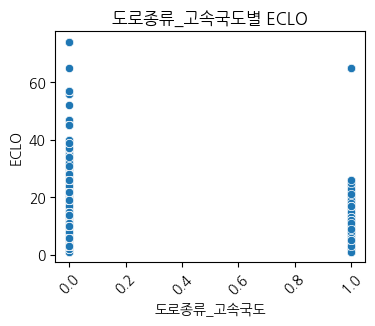

 35%|███▍      | 8/23 [00:13<00:22,  1.48s/it]

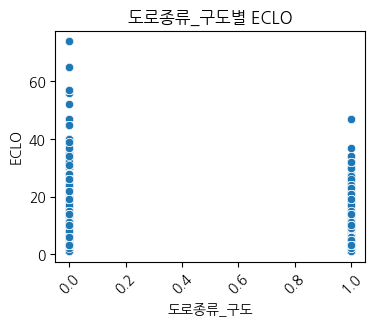

 39%|███▉      | 9/23 [00:14<00:19,  1.42s/it]

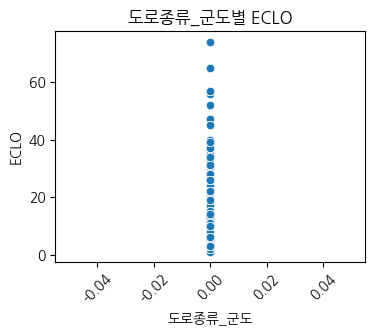

 43%|████▎     | 10/23 [00:15<00:18,  1.39s/it]

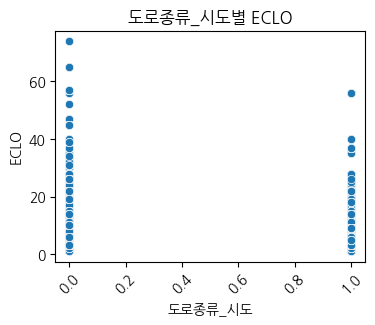

 48%|████▊     | 11/23 [00:16<00:16,  1.36s/it]

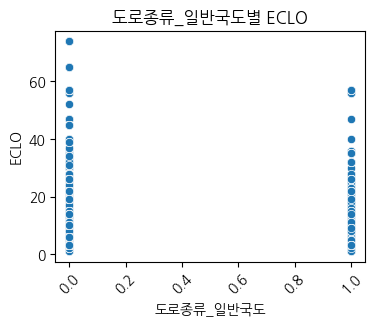

 52%|█████▏    | 12/23 [00:18<00:14,  1.36s/it]

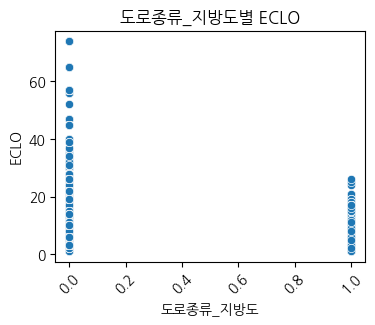

 57%|█████▋    | 13/23 [00:20<00:15,  1.50s/it]

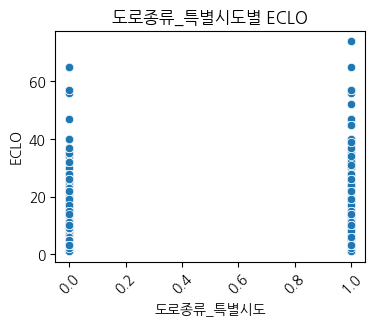

 61%|██████    | 14/23 [00:22<00:14,  1.65s/it]

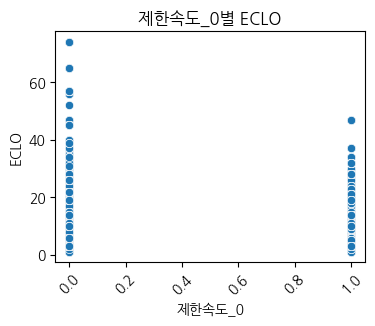

 65%|██████▌   | 15/23 [00:24<00:14,  1.75s/it]

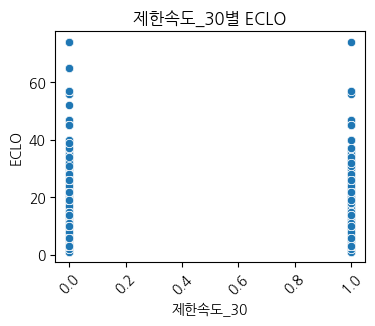

 70%|██████▉   | 16/23 [00:26<00:12,  1.81s/it]

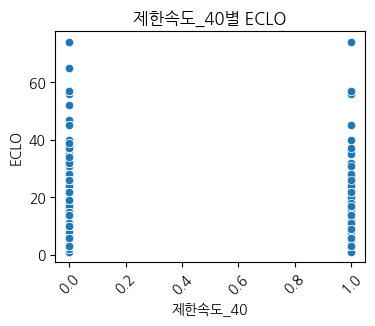

 74%|███████▍  | 17/23 [00:27<00:10,  1.68s/it]

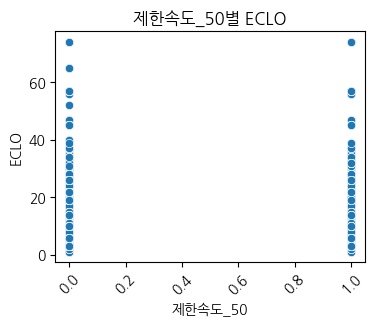

 78%|███████▊  | 18/23 [00:28<00:07,  1.58s/it]

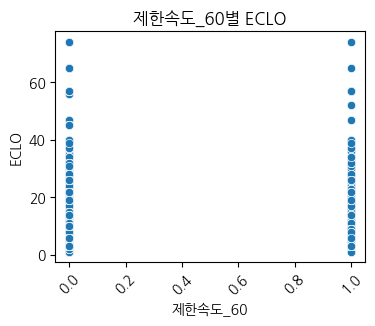

 83%|████████▎ | 19/23 [00:30<00:06,  1.50s/it]

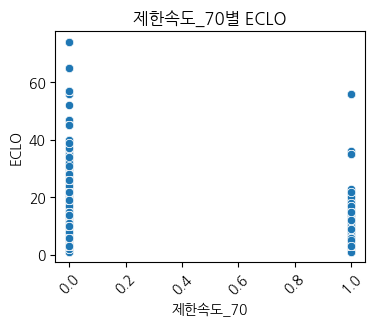

 87%|████████▋ | 20/23 [00:31<00:04,  1.45s/it]

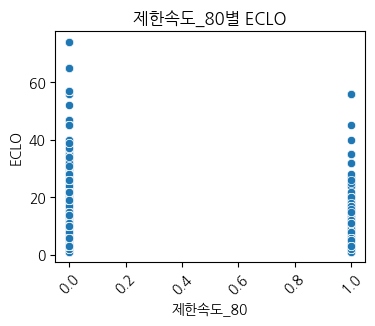

 91%|█████████▏| 21/23 [00:32<00:02,  1.42s/it]

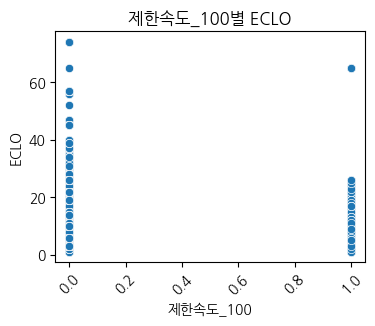

 96%|█████████▌| 22/23 [00:34<00:01,  1.39s/it]

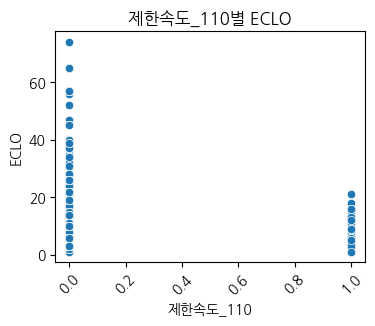

100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


In [37]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-23:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

# 필수 : 보호구역 01, 단속구분 04, 고속국도별, 구도별, 시도별, 일반국도별, 지방도별, 제한속도 0별, 제한속도 70별, 제한속도 80별, 100별, 110별
# 선택 : 단속구분 99, 일반국도별,

In [38]:
DG_cctv['제한속도'].value_counts()

50     274
0      232
30     218
60     187
40      80
80      32
70      22
100     19
110      1
Name: 제한속도, dtype: int64

In [39]:
DG_cctv['보호구역구분'].value_counts()

99.0    522
2.0     366
1.0       5
Name: 보호구역구분, dtype: int64

In [40]:
DG_cctv['단속구분'].value_counts()

2     575
4     232
1     207
99     51
Name: 단속구분, dtype: int64

In [41]:
DG_cctv['도로종류'].value_counts()

특별시도    626
구도      178
시도      132
일반국도     81
지방도      27
고속국도     20
군도        1
Name: 도로종류, dtype: int64

## 어린이 보호구역

In [42]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_children_area[['도시', '구', '동','번지']] = DG_children_area['소재지지번주소'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['소재지지번주소'])

DG_children_area

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [43]:
location_pattern = r'(\S+)~(\S+)'

DG_children_area[['보호구역도로폭_min', '보호구역도로폭_max']] = DG_children_area['보호구역도로폭'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['보호구역도로폭'])

DG_children_area

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,데이터기준일자,도시,구,동,번지,보호구역도로폭_min,보호구역도로폭_max
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,2020-03-23,대구광역시,남구,대명동,1709,6,8
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,2020-03-23,대구광역시,남구,이천동,477,6,10
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,2020-03-23,대구광역시,남구,대명동,3050,8,12
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,2020-03-23,대구광역시,남구,대명동,531-1,6,8
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,2020-03-23,대구광역시,남구,대명동,960,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,2019-06-01,대구광역시,중구,남산동,941-1,6,10
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,2019-06-01,대구광역시,중구,봉산동,57,3,12
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,2019-06-01,대구광역시,중구,남산동,153-2,7,8
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,2019-06-01,대구광역시,중구,남산동,2623-6,6,8


In [ ]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_children_area[['도시','구','동']]

df1 = pd.get_dummies(DG_children_area['시설종류'], prefix = '시설종류')
df2 = pd.get_dummies(DG_children_area['관할경찰서명'], prefix = '관할경찰서명')
df3 = pd.get_dummies(DG_children_area['관리기관명'], prefix = '관리기관명')
df4 = pd.get_dummies(DG_children_area['CCTV설치대수'], prefix = '보호CCTV설치대수')
df5 = pd.get_dummies(DG_children_area['보호구역도로폭_min'], prefix = '보호구역도로폭_min')
df6 = pd.get_dummies(DG_children_area['보호구역도로폭_max'], prefix = '보호구역도로폭_max')



children_area_merge= pd.concat([df, df1, df2, df3, df4, df5, df6], axis=1)
children_area_merge #23개 열

train_df = train_df.merge(children_area_merge, on = ['도시','구','동'], how='left')
test_df = test_df.merge(children_area_merge, on = ['도시','구','동'], how='left')

In [ ]:
children_area_merge.shape

In [ ]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-23:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
DG_children_area['시설종류'].value_counts()

In [ ]:
DG_children_area['관할경찰서명'].value_counts()

In [ ]:
DG_children_area['관리기관명'].value_counts()

In [ ]:
DG_children_area['CCTV설치대수'].value_counts()

In [ ]:
DG_children_area['보호구역도로폭_min'].value_counts()

In [ ]:
DG_children_area['보호구역도로폭_max'].value_counts()

## 주차장